## Chapter 3 - Exercise 3

Tackle the Kaggle Titanic dataset
* predict which passengers survived

Notes on the data:
      * survival    Survival 	    0 = No,  1 = Yes
      * pclass      Ticket class 	1 = 1st, 2 = 2nd, 3 = 3rd
      * sex         Sex 	
      * age 	    Age in years
                      Fractional if less than 1.
                      If estimated, in form of xx.5
      * sibsp       Number of siblings + spouses aboard the Titanic 	
      * parch       Number of parents + children aboard the Titanic 	
      * ticket      Ticket number 	
      * fare        Passenger fare 	
      * cabin       Cabin number 	
      * embarked    Port of Embarkation 	
                      C = Cherbourg, Q = Queenstown, S = Southampton


To do:

    data exploration
    
       correlations

    include cleaning in pipeline

    separate numeric and categorical

    impute missing ages
      include was_imputed?
      
    impute other numerics in case they are missing in test or deployed data
    
    add age ** 2 feature
    
    use ages to estimate split of sibsp in sib sp and parch in par ch
    
    one-hot encode categorical
    
    join numeric and categorical
    
    try different models
      cross-validation
    
    try different hyper parameters
      cross-validation
    
    more feature engineering
    
    compare to text notebook
    
    submit to kaggle


Brainstorm:

    pclass as categorical or numeric?
   
    sibsp separate into sib and sp, estimating based on age?
      assume > 18 and sibsp = 1 --> sp = 1 sib = 0; else sib = sibsp?
    
    parch separate into par and ch, estimating based on age?
      assume age > 18 ch = parch; else par = parch?
        seems more dubious (ie. age 20, could easily be ch or par?)
        
    few examples of high fares may through off regression?

### Set up notebook environment

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

In [2]:
# Settings
pd.set_option('max_rows', 7)
pd.set_option('max_columns', 50)
%matplotlib inline
plt.style.use('fivethirtyeight')

### Load and clean the data

In [3]:
# Load data 
data = pd.read_csv('datasets/titanic/train.csv')

# Column names as lower case strings
data.columns = map(str.lower, data.columns)

### Data Exploration

In [4]:
print('Total passengers in data: {0}'.format(len(data)))

Total passengers in data: 891


In [5]:
# Numeric data
data.describe().T

,count,mean,std,min,25%,50%,75%,max
passengerid,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
sibsp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


Raw numeric data notes:
 * 177 of 891 missing age data
 * passengerid should likely be excluded
 * pclass should likely be treated as categorical
 * sibsp and parch may benefit from an attempt to separate
   + could make assumptions based on age and number
   + why are these together anyway?
 

In [6]:
# Categorical data
data.select_dtypes(include=['object']).describe().T

,count,unique,top,freq
name,891,891,"Blackwell, Mr. Stephen Weart",1
sex,891,2,male,577
ticket,891,681,1601,7
cabin,204,147,B96 B98,4
embarked,889,3,S,644


Raw categorical data notes:
* Most entries missing cabin (687 out of 891)
  + Might use cabin vs no cabin
  + Cabin letter and number may also be informative
* 2 missing embarked
  + not enough to make NA class, probably just use mode

,survived,count
0,No,549
1,Yes,342


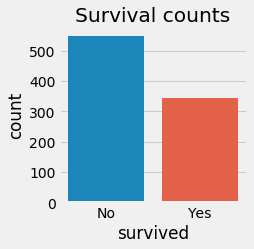

In [7]:
# Survival counts
plt.figure(figsize=(3,3))
survived_count = (data.survived.value_counts()
                      .to_frame(name='count')
                      .rename({0:'No', 1:'Yes'})
                      .reset_index()
                      .rename({'index':'survived'}, axis=1)
                 )
display(survived_count)

sns.barplot(x='survived', y='count', data=survived_count)
plt.title('Survival counts')
plt.show()

male      577
female    314
Name: sex, dtype: int64

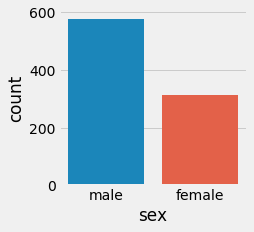

In [8]:
# Gender count
display(data.sex.value_counts())
plt.figure(figsize=(3,3))
sns.countplot(data=data, x=data.sex)
plt.show()

1    216
2    184
3    491
Name: pclass, dtype: int64

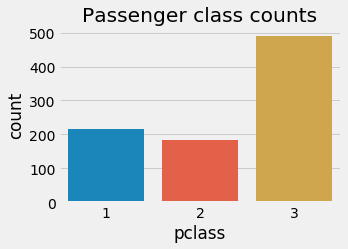

In [9]:
# Passanger class counts
plt.figure(figsize=(4.5, 3))
display(data.pclass.value_counts().sort_index())
sns.countplot(data=data, x='pclass')
plt.title('Passenger class counts')
plt.show()

Notes:
* survival, sex, pclass look balanced enough to not require stratification

Count of missing age data = 177


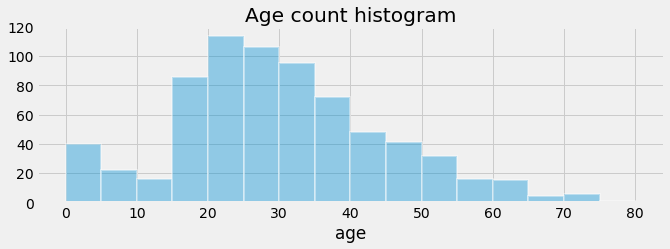

In [10]:
# Age data missing
print('Count of missing age data = {}'.format(data.age.isnull().sum()))

# Age count histogram
plt.figure(figsize=(10, 3))
sns.distplot(data.loc[data.age.notnull()].age, hist=True, kde=False, 
             bins=np.arange(0, 81, 5),
             hist_kws={'edgecolor':'white', 'linewidth':2})
plt.title('Age count histogram')
plt.show()

Age notes:
* Might add age ** 2 feature for the possibility that children and elderly were treated similarly

0    608
1    209
2     28
3     16
4     18
5      5
8      7
Name: sibsp, dtype: int64

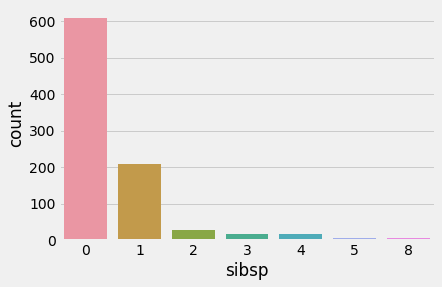

In [11]:
# Sibsp value counts
display(data.sibsp.value_counts().sort_index())
sns.countplot(data.sibsp)
plt.show()

0    678
1    118
2     80
3      5
4      4
5      5
6      1
Name: parch, dtype: int64

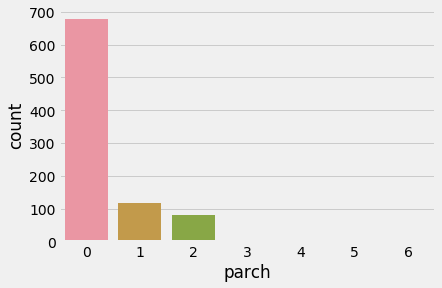

In [12]:
# Parch value counts
display(data.parch.value_counts().sort_index())
sns.countplot(data.parch)
plt.show()

Number of fares greater than 200 = 20


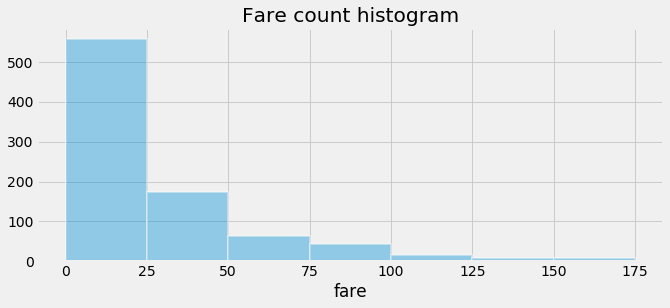

In [13]:
# Fare histogram
print('Number of fares greater than 200 = {0}'.format(
                                               len(data.loc[data.fare > 200])))

plt.figure(figsize=(10, 4))
sns.distplot(data.fare, hist=True, kde=False, 
             bins=np.arange(0, 200, 25),
             hist_kws={'edgecolor':'white', 'linewidth':2})
plt.title('Fare count histogram')
plt.show()

In [14]:
# Potential feature engineering

# age squared
data['age_sq'] = data['age'] ** 2

# age estimated
data['age_adj'] = data.apply(lambda row: np.floor(row.age) if row.age % 1 == 0.5 
                             else row.age, axis=1)

data['age_was_estimated'] = data.age % 1 == 0.5

# sibsp and parch splits
#   make some assumptions
data['sib'] = data.apply(lambda row: row.sibsp if row.sibsp > 1 or row.age < 18 
                   else 0, axis=1)
data['sp'] = data.apply(lambda row: row.sibsp if row.sibsp == 1 and row.age >= 18 
                   else 0, axis=1)

data['par'] = data.apply(lambda row: row.parch if row.parch <= 2 and row.age < 18 
                   else 0, axis=1)
data['ch'] = data.apply(lambda row: row.parch if row.parch > 2 or row.age >= 18 
                   else 0, axis=1)

In [15]:
# Correlations
with pd.option_context('max_row', None):
    display(data.corr()['survived'].sort_values(ascending=False))

survived             1.000000
fare                 0.257307
par                  0.096788
sp                   0.088965
parch                0.081629
ch                   0.054630
passengerid         -0.005007
sibsp               -0.035322
age_sq              -0.055645
age_adj             -0.076626
sib                 -0.076993
age                 -0.077221
age_was_estimated   -0.096929
pclass              -0.338481
Name: survived, dtype: float64

Notes:
* Correlation with parents may be due to correlation with age, especially with age based assumptions used to split parch
  + If using split be sure to exclude initial unsplit categories to ensure linear independence
* Might recast age as categorical (i.e. kid, teen, middle age, elderly)

### Machine Learning

In [16]:
# Numerical transformer pipeline
num_features = ['sibsp', 'parch', 'fare', 'age']

num_trans = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    #('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

In [17]:
# Categorical transformer pipeline
cat_features = ['embarked', 'sex', 'pclass']

cat_trans = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

In [18]:
# Combined preprocessor pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', num_trans, num_features),
    ('cat', cat_trans, cat_features)
])

In [21]:
# test of preprocessor pipeline / show processed data??

# old num test, remake

#X_num = X.loc[:, num_features]
#X_num_tr = pd.DataFrame(num_pipeline.fit_transform(X_num), 
#                        columns=num_features)

#X_num_tr

In [22]:
# Classifier pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(solver='lbfgs'))])

y = np.ravel(data.loc[:, ['survived']])
X = data.drop(['survived'], axis=1)  

clf.fit(X, y)
print("model score: %.3f" % clf.score(X, y))

model score: 0.806


In [ ]:
# Hyperparameter search
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__C': [0.1, 1.0, 10, 100],
}

grid_search = GridSearchCV(clf, param_grid, cv=10, iid=False)
grid_search.fit(X_train, y_train)

print(("best logistic regression from grid search: %.3f"
       % grid_search.score(X_test, y_test)))

In [ ]:
# Separate sibsp and parch
#   this might be done better with ColumnTransformer

# column index
age_ix, sibsp_ix, parch_ix = 0, 1, 2

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    ''' Add feature engineered attributes 
         separate sibsp into sib and sp
           assumes if sibsp > 1 or age < age_cutoff sibsp = sib
                   else sibsp = sp
         
         not implemented - separate parch into par and ch
           assumes if parch > 2 or age < age_cutoff parch = par; 
                   else parch = ch
    '''
    
    def __init__(self, age_cutoff=18):   # no *args or **kargs
        self.age_cutoff = age_cutoff
        
    def fit(self, X, y=None):
        return self                      # nothing else to do
    
    def transform(self, X, y=None):
        # X is a numpy array here -> can't use pandas
        
        sib = (((X[:, sibsp_ix] > 1) | (X[:, age_ix] < self.age_cutoff)) * 
               X[:, sibsp_ix])
        
        sp = (((X[:, sibsp_ix] <= 1) & (X[:, age_ix] >= self.age_cutoff)) * 
               X[:, sibsp_ix])
        
        return np.c_[X, sib, sp]
            
# Sanity check
#X_num_tr.loc[X_num_tr.sib + X_num_tr.sp != X_num_tr.sibsp]

In [ ]:
# Adjust estimated ages?

# Add to ColumnTransformer?
    ('age_adj', Pipeline([('age_trans', age_trans()),
                          ('imput', SimpleImputer(strategy='median')),
                          ('std_scaler', StandardScaler())]), 
                ['age']),

# Class for transformation

  # test that it's doing something

class age_trans(BaseEstimator, TransformerMixin):
    ''' Remove the .5 flag from estimated ages in the raw data '''
    
    def fit(self, X, y=None):
        return self                      
    
    def transform(self, X, y=None):
        X['age'] = X.apply(lambda row: np.floor(row.age) if row.age % 1 == 0.5 
                           else row.age, axis=1)
        return X